# Notebook 2: Generating Binding Features


Compute binding/interaction features for each cross-species ligand–receptor pair using the Xeno source code wrappers and ipSAE. The notebook runs BindCraft and PRODIGY from `./Xeno source code/`, executes ipSAE via `ipSAE/run_ipsae.ps1`, parses all raw outputs, and consolidates them into a single feature table.

**Inputs**

* `./Xeno source code/` (wrappers/scripts for BindCraft & PRODIGY)
* `ipSAE/run_ipsae.ps1` (PowerShell runner for ipSAE)

**Output**

* Manuscript supplementry data

## Outline

1. **BindCraft Features**
   Invoke BindCraft via the Xeno wrappers in `./Xeno source code/`; extract interface metrics and write intermediate results.

2. **PRODIGY Features**
   Run PRODIGY through the same wrappers to obtain ΔG/affinity estimates and contact descriptors; save parsed outputs.

3. **ipSAE Features**
   Execute `ipSAE/run_ipsae.ps1` to generate ipSAE descriptors; collect the produced feature files.



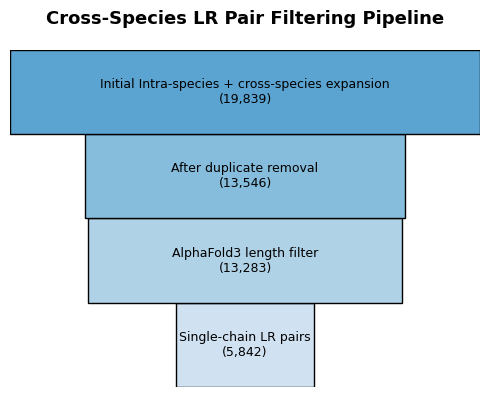

In [20]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
import matplotlib.pyplot as plt
import numpy as np
import os 

figures_dir = r"Z:\MorrissyLab Dropbox\Manuscripts_in_progress\XenoSignalDB\RawFigures\fig1"


# Data
stages = [
    "Initial Intra-species + cross-species expansion",
    "After duplicate removal",
    "AlphaFold3 length filter",
    "Single-chain LR pairs"
]

lr_counts = [19839, 13546, 13283, 5842]

# Normalize widths
max_width = max(lr_counts)
widths = np.array(lr_counts) / max_width

# Reverse for top-down visualization
stages = stages[::-1]
lr_counts = lr_counts[::-1]
widths = widths[::-1]

# Lighter blue gradient
colors = plt.cm.Blues(np.linspace(0.2, 0.55, len(stages)))

# Create figure
fig, ax = plt.subplots(figsize=(5, 4))

n_layers = len(widths)
layer_height = 1.0 / n_layers

for i in range(n_layers):
    top_y = i * layer_height
    bottom_y = (i + 1) * layer_height
    half_width = widths[i] / 2

    # Rectangle coordinates
    coords = [
        [0.5 - half_width, top_y],
        [0.5 + half_width, top_y],
        [0.5 + half_width, bottom_y],
        [0.5 - half_width, bottom_y]
    ]

    polygon = plt.Polygon(coords, closed=True, edgecolor='black', facecolor=colors[i])
    ax.add_patch(polygon)

    # Add text label
    ax.text(0.5, top_y + layer_height / 2,
            f"{stages[i]}\n({lr_counts[i]:,})",
            ha='center', va='center', fontsize=9)

# Formatting
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.axis('off')

# Title
fig.suptitle("Cross-Species LR Pair Filtering Pipeline", fontsize=13, weight='bold')

plt.tight_layout()
plt.savefig(os.path.join(figures_dir,"filtering_pipeline.pdf"))
plt.show()

## 1. BindCraft Features

In [ ]:
from xeno.pyrosetta_utils import score_interface
from xeno.biopython_utils import calc_ss_percentage, calculate_clash_score
from xeno.features import calc_pdockq
import json
import os
from tqdm import tqdm
import gemmi
import random


def convert_cif_to_pdb(input_cif: str):
    """
    Reads a CIF file and saves it as a PDB file.

    Parameters:
    input_cif (str): Path to the input CIF file.
    """
    output_dir = "/mnt/c/Temp"
    os.makedirs(output_dir, exist_ok=True)  # Ensure the directory exists
    output_pdb = os.path.join(output_dir, os.path.basename(input_cif).replace(".cif", ".pdb"))

    # Read the CIF structure
    structure = gemmi.read_structure(input_cif)
    
    # Save it as a PDB file
    if not os.path.exists(output_pdb):
        structure.write_pdb(output_pdb)
        # print(f"Saved PDB file to {output_pdb}")

    return output_pdb, structure


def calculate_all_binding_features(structure_file_path):
    

    pdb_file_path, structure = convert_cif_to_pdb(structure_file_path)

    # print("Calculate pdocq")
    pdockq, ppv, n_if_contacts = calc_pdockq(structure)
    # print("Calculate rosetta features")
    mpnn_interface_scores, mpnn_interface_AA, mpnn_interface_residues = score_interface(pdb_file_path)
    # print("Calculate biopython features")
    mpnn_alpha, mpnn_beta, mpnn_loops, mpnn_alpha_interface, mpnn_beta_interface, mpnn_loops_interface, mpnn_i_plddt, mpnn_ss_plddt = calc_ss_percentage(pdb_file_path, chain_id="B", atom_distance_cutoff=4.0)
    num_clashes_mpnn = calculate_clash_score(pdb_file_path)

    ## Already works with cif
    features_dict = {
                'i_pLDDT': mpnn_i_plddt,
                'ss_pLDDT': mpnn_ss_plddt,
                'mpnn_interface_residues': mpnn_interface_residues,
                'Unrelaxed_Clashes': num_clashes_mpnn,
                'Binder_Energy_Score': mpnn_interface_scores['binder_score'],
                'Surface_Hydrophobicity': mpnn_interface_scores['surface_hydrophobicity'],
                'ShapeComplementarity': mpnn_interface_scores['interface_sc'],
                'PackStat': mpnn_interface_scores['interface_packstat'],
                'dG': mpnn_interface_scores['interface_dG'],
                'dSASA': mpnn_interface_scores['interface_dSASA'],
                'dG/dSASA': mpnn_interface_scores['interface_dG_SASA_ratio'],
                'Interface_SASA_%': mpnn_interface_scores['interface_fraction'],
                'Interface_Hydrophobicity': mpnn_interface_scores['interface_hydrophobicity'],
                'n_InterfaceResidues': mpnn_interface_scores['interface_nres'],
                'n_InterfaceHbonds': mpnn_interface_scores['interface_interface_hbonds'],
                'InterfaceHbondsPercentage': mpnn_interface_scores['interface_hbond_percentage'],
                'n_InterfaceUnsatHbonds': mpnn_interface_scores['interface_delta_unsat_hbonds'],
                'InterfaceUnsatHbondsPercentage': mpnn_interface_scores['interface_delta_unsat_hbonds_percentage'],
                'InterfaceAAs': mpnn_interface_AA,
                'Interface_Helix%': mpnn_alpha_interface,
                'Interface_BetaSheet%': mpnn_beta_interface,
                'Interface_Loop%': mpnn_loops_interface,
                'Binder_Helix%': mpnn_alpha,
                'Binder_BetaSheet%': mpnn_beta,
                'Binder_Loop%': mpnn_loops,
                'pdockq': float(pdockq),
                'ppv': float(ppv),
                'n_if_contacts': n_if_contacts
    }

    return features_dict

results_dir = '/mnt/z/xenosignaldb/alphafold_results'
models_list = list(range(5))  # Change number of models

# Get a shuffled list of job names
job_names = os.listdir(results_dir)#[::-1]
job_names = sorted(job_names, key=lambda x: int(x[3:].split('_')[0]))

total_jobs = len(job_names) * len(models_list)

with tqdm(total=total_jobs, desc="Processing jobs") as pbar:
    for job_name in job_names:
        job_path = os.path.join(results_dir, job_name)

        for model_number in models_list:
            pbar.set_description(f"Processing {job_name} model_id={model_number}")  # Update description with job name
            structure_file_path = os.path.join(job_path, f"fold_{job_name}_model_{model_number}.cif")
            features_file_path = structure_file_path.replace("_model_", "_features_").replace(".cif", ".json")

            if os.path.exists(features_file_path):
                pbar.set_description(f"Already processed {job_name} model_id={model_number}")
                continue  
            try:
                
                name_list = job_name.split('_')  # Fix name extraction
                if len(name_list) == 5 or name_list[1].startswith(("hla", "h2", "h1")):
                    features_dict = calculate_all_binding_features(structure_file_path)
                    with open(features_file_path, "w") as f:
                        json.dump(features_dict, f, indent=4)

            except Exception as e:  
                print(f"Error with {structure_file_path}: {e}")

            pbar.update(1)  # Update the progress bar

In [ ]:
data_path = r"Z:\xenosignaldb\alphafold_results"

# Output list
output = []

for sample in tqdm(os.listdir(data_path)):
    sample_path = os.path.join(data_path, sample)
    for model_id in range(5):
        features_path = os.path.join(sample_path, f"fold_{sample}_features_{model_id}.json")
        if os.path.exists(features_path):
            with open(features_path, 'r') as f:
                results = json.load(f)
                results['File Name'] = f'fold_{sample}_model_{model_id}.cif'
                output.append(results)

df = pd.DataFrame(output)
df.to_csv("bindcraft_af3_features_all.csv", index=False)

## 2. Prodigy Features

In [ ]:
from pathlib import Path
import logging

from prodigy_prot.modules.parsers import parse_structure
from prodigy_prot.modules.prodigy import Prodigy
import re
import json
from glob import glob
import pandas as pd
from tqdm import tqdm
import os

def predict_binding_affinity(input_path: str):
    """
    Predict binding affinity using Prodigy with default parameters.

    Args:
        input_path (str): Path to a structure file (.pdb, .cif) or directory containing such files.

    Returns:
        List of dicts: Each dict contains detailed prediction results per structure.
    """
    logging.basicConfig(level=logging.INFO, format="%(message)s")
    log = logging.getLogger("Prodigy")
    
    distance_cutoff = 5.5
    acc_threshold = 0.05
    temperature = 25.0
    selection = None  # Default: use automatic molecule selection based on chain IDs
    
    struct_path = Path(input_path)
    input_list = []

    if struct_path.is_file():
        input_list.append(struct_path)
    elif struct_path.is_dir():
        #input_list.extend(f for f in struct_path.glob("*") if f.suffix in [".pdb", ".cif", ".ent"])
        input_list.extend(f for f in struct_path.glob("*") if f.suffix in [".cif", ".ent"])
    else:
        raise FileNotFoundError(f"Input path {input_path} is not a valid file or directory")

    results = []
    for input_f in input_list:
        base_name = os.path.basename(input_f)
        model_id = base_name.rsplit('_model_', 1)[-1].removesuffix('.cif')
        json_filename = re.sub(r'_model_\d+\.cif$', f'_summary_confidences_{model_id}.json', base_name)
        json_path = os.path.join(os.path.dirname(input_f), json_filename)

        
        structure, n_chains, n_res = parse_structure(str(input_f))
        # log.info(f"[+] Parsed structure file {structure.id} ({n_chains} chains, {n_res} residues)")

        prodigy = Prodigy(structure, selection, temperature)
        prodigy.predict(distance_cutoff=distance_cutoff, acc_threshold=acc_threshold)

        result = {
            "Structure ID": structure.id,
            "File Name": input_f.name,
            "Number of Chains": n_chains,
            "Number of Residues": n_res,
            "Number of Intermolecular Contacts": len(prodigy.ic_network),
            "Charged-Charged Contacts": prodigy.bins["CC"],
            "Charged-Polar Contacts": prodigy.bins["CP"],
            "Charged-Apolar Contacts": prodigy.bins["AC"],
            "Polar-Polar Contacts": prodigy.bins["PP"],
            "Apolar-Polar Contacts": prodigy.bins["AP"],
            "Apolar-Apolar Contacts": prodigy.bins["AA"],
            "Percentage of Apolar NIS Residues": prodigy.nis_a,
            "Percentage of Charged NIS Residues": prodigy.nis_c,
            "Predicted Binding Affinity (kcal/mol)": prodigy.ba_val,
            "Predicted Dissociation Constant (Kd, M)": prodigy.kd_val,
            "Temperature (°C)": prodigy.temp,
        }

        with open(json_path, 'r') as f:
            data = json.load(f)

        dict2_prefixed = {f'af3_{k}': v for k, v in data.items()}
        
        result.update(dict2_prefixed)

        results.append(result)

    return results

data_path = r"Z:\xenosignaldb\alphafold_results"

# Output list
output = []

# Process each sample
for sample in tqdm(os.listdir(data_path)):
    sample_path = os.path.join(data_path, sample)
    prodigy_path = os.path.join(sample_path, f"{sample}_prodigy_features.json")
    
    try:
        if os.path.exists(prodigy_path):
            with open(prodigy_path, 'r') as f:
                results = json.load(f)
        else:
            results = predict_binding_affinity(sample_path)
            with open(prodigy_path, 'w') as fout:
                json.dump(results, fout)
                
        output.extend(results)
        
    except Exception as e:
        print(f"Error processing {sample_path}: {e}")
        continue

# Save to CSV
df = pd.DataFrame(output)
df.to_csv("prodigy_af3_features_all.csv", index=False)

In [1]:
import os 
import pandas as pd 


## features

bind_df = pd.read_csv("cell-cell-data/bindcraft_af3_features_all.csv")
bind_df.set_index("File Name",inplace=True)
prod_df = pd.read_csv("cell-cell-data/prodigy_af3_features_all.csv")
prod_df.set_index("File Name",inplace=True)


## metadata
xeno_df = pd.read_csv("cell-cell-data/xenosignal_db_v2.csv", index_col=0)
xeno_df.set_index("file_path",inplace=True)
cellchat_db = pd.read_csv("cell-cell-data/cellchat_interactions_ortho_v2024.csv", index_col=0)
cellchat_db.set_index("job_name",inplace=True)
# cellchat_db.to_csv("cell-cell-data/cellchat_interactions_ortho_v2025.csv")

merged_df = pd.merge(prod_df, bind_df, left_index=True, right_index=True, how="outer")
merged_df.index = merged_df.index.astype(str).str.replace(".cif", "", regex=False)
merged_df.drop("Structure ID", axis=1, inplace=True)
merged_df.index = merged_df.index.astype(str)
extracted = merged_df.index.str.extract(r"fold_(job\d+_.*)_model_(\d+)", expand=True)
merged_df.insert(0, "Interaction Name", extracted[0].values)
merged_df.insert(1, "Model Number", extracted[1].values)


# Perform the join
joined_df = merged_df.join(xeno_df, on="Interaction Name", how="left", rsuffix="_xeno")
# Get list of columns
first_cols = joined_df.columns[:2]                 # ['Interaction Name', 'Model Number']
xeno_cols = xeno_df.columns.tolist()               # All columns from xeno_df
remaining_cols = joined_df.columns[2:-len(xeno_cols)] if len(xeno_cols) else joined_df.columns[2:]

# Reorder columns: first 2, then xeno_df's, then the rest
joined_df = joined_df[list(first_cols) + xeno_cols + list(remaining_cols)]
joined_df.to_csv("cell-cell-data/xenosignal_db_features_all_v2.csv")

C:\Users\alyos\AppData\Local\Temp\ipykernel_23776\1627433932.py:16: DtypeWarning: Columns (5,33) have mixed types. Specify dtype option on import or set low_memory=False.
  cellchat_db = pd.read_csv("cell-cell-data/cellchat_interactions_ortho_v2024.csv", index_col=0)


## 4. IPSAE Features

In [ ]:
import os
from pathlib import Path
from tqdm import tqdm
import pandas as pd

data_path = Path(r"Z:\xenosignaldb\alphafold_results")
all_dfs = []

for sample_dir in tqdm(data_path.iterdir(), desc="Processing samples"):
    if not sample_dir.is_dir():
        continue

    for i in range(5):
        file_path = sample_dir / f"fold_{sample_dir.name}_model_{i}_10_10.txt"
        if file_path.exists():
            try:
                df = pd.read_csv(file_path, sep=r'\s+')
                # Precompute metadata
                df['job_name'] = sample_dir.name
                df['model_id'] = str(i)
                df = df.rename(columns={'Model': 'model_path'})
                all_dfs.append(df)
            except:
                print(file_path)
# Concatenate all dataframes
df_all = pd.concat(all_dfs, ignore_index=True)

# Reorder columns
cols = ['job_name', 'model_id'] + [col for col in df_all.columns if col not in ['job_name', 'model_id']]
df_all = df_all[cols]
df_all.to_csv("cell-cell-data/ipsae_features_all_without_annotation.csv")

Processing samples: 13265it [15:08, 14.60it/s]


In [11]:
import os

import numpy as np
import pandas as pd

df_all = pd.read_csv("cell-cell-data/ipsae_features_all_without_annotation.csv", index_col=0)
xeno_df = pd.read_csv("cell-cell-data/xenosignal_db.csv", index_col=0)
xeno_df.set_index("file_path",inplace=True)
joined_df = df_all.join(xeno_df, on="job_name", how="left", rsuffix="_xeno")

# joined_df.to_csv("cell-cell-data/ipsae_features_all.csv")